                                                     **AI : PriceOptima**                                                                
                                                             By Himasish Ghosal                                                             

# **Project Objective**
To design and implement a machine learning–driven dynamic pricing system that adjusts prices in real-time or periodically to maximize revenue and maintain competitiveness. The system will leverage historical sales, inventory to predict optimal prices using advanced ML techniques. By ensuring adaptability and transparency, the platform will help businesses increase profitability while preserving customer trust.

# **Milestone 1: Requirements & Data Preparation**

**Possible KPI's**

`Revenue Lift (%) → ((New - Old) / Old) × 100`

`Profit Margin (%) → ((Revenue - Cost) / Revenue) × 100`

`Conversion Rate (%) → (Completed / Total) × 100 `

In [1]:
# KPI calculation functions
def revenue_lift(old, new):
    if old == 0:
        raise ValueError("Old revenue must be non-zero.")
    return ((new - old) / old) * 100


def profit_margin(revenue, cost):
    if revenue == 0:
        raise ValueError("Revenue must be non-zero.")
    return ((revenue - cost) / revenue) * 100


def conversion_rate(completed, total):
    if total == 0:
        raise ValueError("Total must be non-zero.")
    return (completed / total) * 100


# To Store KPI details in a dictionary
kpis = {
    "Revenue Lift": {
        "formula": "((New - Old) / Old) * 100",
        "description": "Increase in revenue (%)",
        "function": revenue_lift
    },
    "Profit Margin": {
        "formula": "((Revenue - Cost) / Revenue) * 100",
        "description": "Profit as % of revenue",
        "function": profit_margin
    },
    "Conversion Rate": {
        "formula": "(Completed / Total) * 100",
        "description": "Success ratio (%)",
        "function": conversion_rate
    }
}


def print_kpi_reference():
    print(f'{"KPI":20} | {"Formula":35} | {"Description"}')
    print("-" * 80)
    for name, info in kpis.items():
        print(f'{name:20} | {info["formula"]:35} | {info["description"]}')



## Installation Of  Required Libraries

In [ ]:
%pip install numpy pandas scikit-learn matplotlib seaborn scipy

In [ ]:
%pip install xgboost lightgbm catboost
%pip install flask fastapi uvicorn
%pip install joblib

## Import Section For Data Preparation

In [4]:
import pandas as pd
import numpy as np

In [5]:
df=pd.read_csv("dynamic_pricing.csv")
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


# **Milestone 2: Data Ingestion Pipeline**

In [6]:
def data_ingestion_pipeline(filepath):
    # To Load data
    df = pd.read_csv(filepath)
    print("Dataset Info:")
    df.info()
    # To Drop duplicates
    df = df.drop_duplicates()
    
    # Handle missing values (simple imputation: fill numeric with mean, categorical with mode)
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Reset index after cleaning
    df = df.reset_index(drop=True)
    
    return df

In [7]:
cleaned_df = data_ingestion_pipeline("dynamic_pricing.csv")
print("cleaned_df created")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB
cleaned_df created


In [8]:
cleaned_df.to_csv("cleaned_dynamic_pricing.csv", index=False)
print("cleaned_dynamic_pricing.csv saved")

cleaned_dynamic_pricing.csv saved


# **Milestone 3: Exploratory Data Analysis (EDA)**

## Advanced EDA: Nulls, Duplicates, Inconsistencies

In [9]:
print('Null values per column:')
print(cleaned_df.isnull().sum())

Null values per column:
Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64


In [10]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB


In [11]:
print('\nDuplicate rows:', cleaned_df.duplicated().sum())


print('\nSummary statistics:')
print(cleaned_df.describe()) # Only for numerical columns


Duplicate rows: 0

Summary statistics:
       Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean          60.372000          27.076000             50.031000   
std           23.701506          19.068346             29.313774   
min           20.000000           5.000000              0.000000   
25%           40.000000          11.000000             25.000000   
50%           60.000000          22.000000             51.000000   
75%           81.000000          38.000000             75.000000   
max          100.000000          89.000000            100.000000   

       Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  
count      1000.000000              1000.00000              1000.000000  
mean          4.257220                99.58800               372.502623  
std           0.435781                49.16545               187.158756  
min           3.500000                10.00000     

In [12]:
cleaned_df.describe(include='object')# Only for categorical columns

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,1000,1000,1000,1000
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,346,367,276,522


## Basic Visualization: Distribution of Numeric Features

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

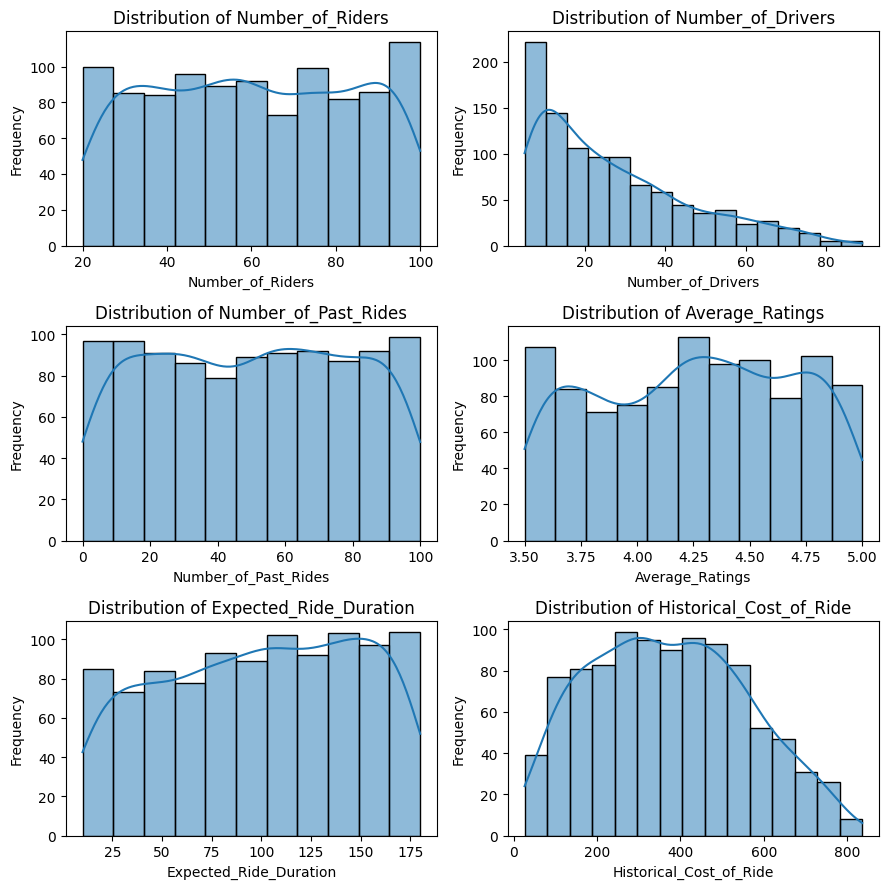

In [14]:

numeric_cols = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = len(numeric_cols)
cols = 2  # Number of columns in the subplot grid
rows = math.ceil(num_cols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(9, 3 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(cleaned_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Outlier Detection: Boxplot and IQR  

In [15]:
from scipy import stats

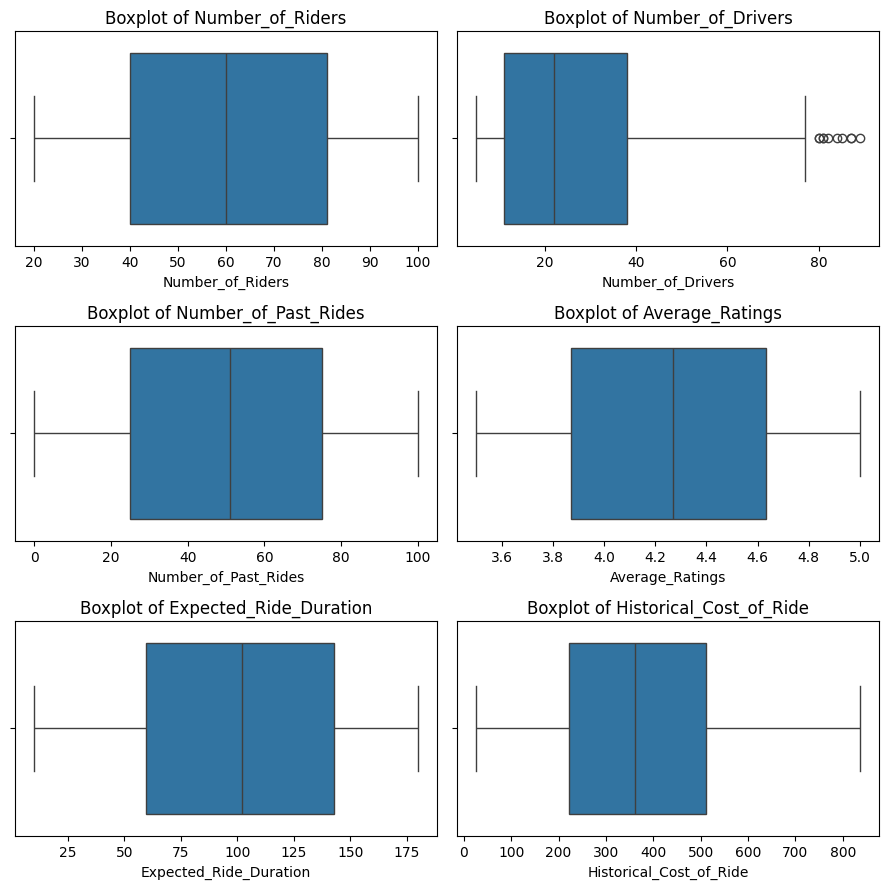

In [16]:
num_cols = len(numeric_cols)
cols = 2  # Number of columns in the subplot grid
rows = math.ceil(num_cols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(9, 3 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=cleaned_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [17]:
outliers_iqr = {}
for col in numeric_cols:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)].index
    outliers_iqr[col] = outlier_indices
    print(f'Outliers in {col} (IQR method):', len(outlier_indices))

Outliers in Number_of_Riders (IQR method): 0
Outliers in Number_of_Drivers (IQR method): 10
Outliers in Number_of_Past_Rides (IQR method): 0
Outliers in Average_Ratings (IQR method): 0
Outliers in Expected_Ride_Duration (IQR method): 0
Outliers in Historical_Cost_of_Ride (IQR method): 0


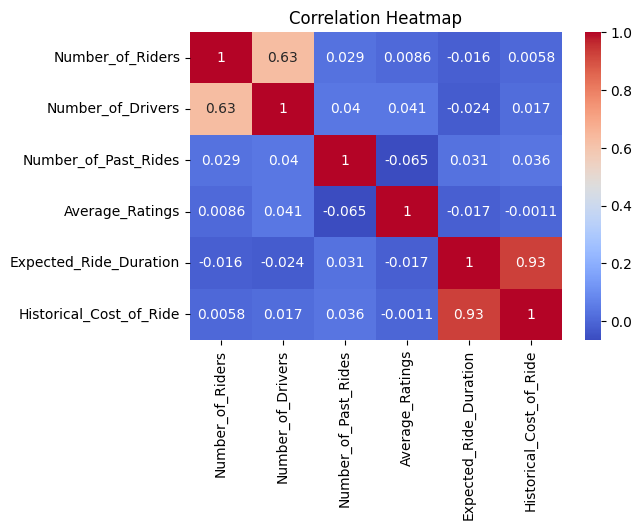

In [18]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
corr = cleaned_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Scatter Plot For Linear Relationship

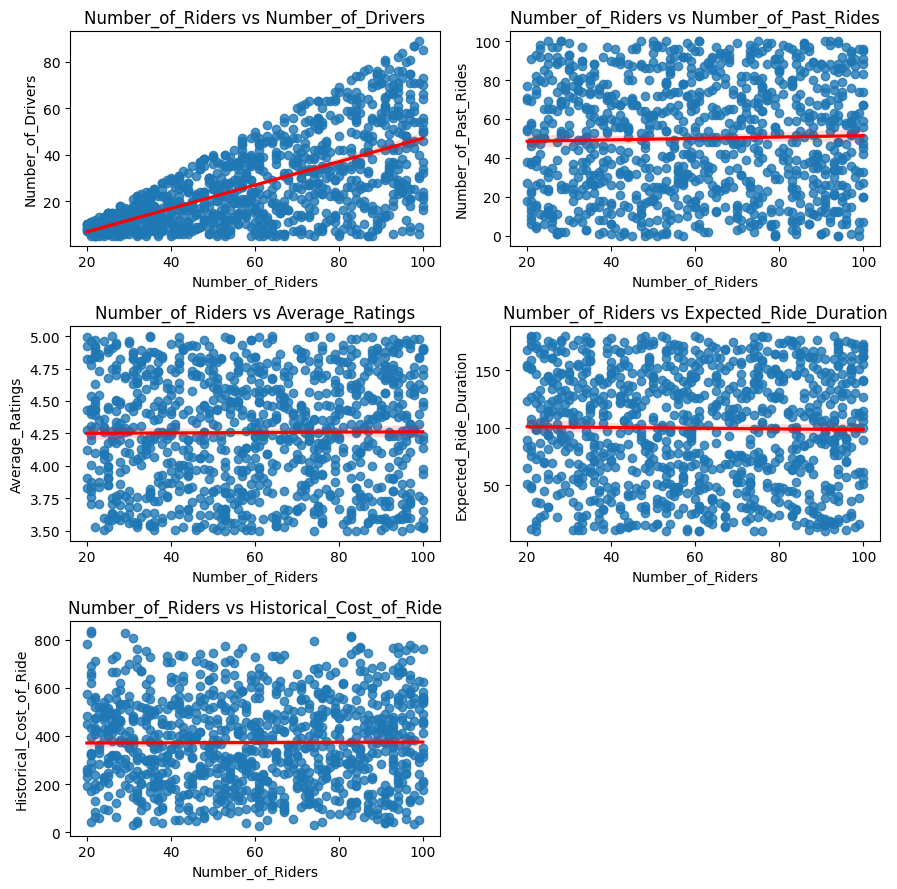

In [19]:
num_cols = len(numeric_cols)
cols = 2  
rows = math.ceil((num_cols - 1) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(9, 3 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[1:]):
    sns.regplot(x=cleaned_df[numeric_cols[0]], y=cleaned_df[col], ax=axes[i], scatter=True, line_kws={'color': 'red'})
    axes[i].set_title(f'{numeric_cols[0]} vs {col}')
    axes[i].set_xlabel(numeric_cols[0])
    axes[i].set_ylabel(col)

# To Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

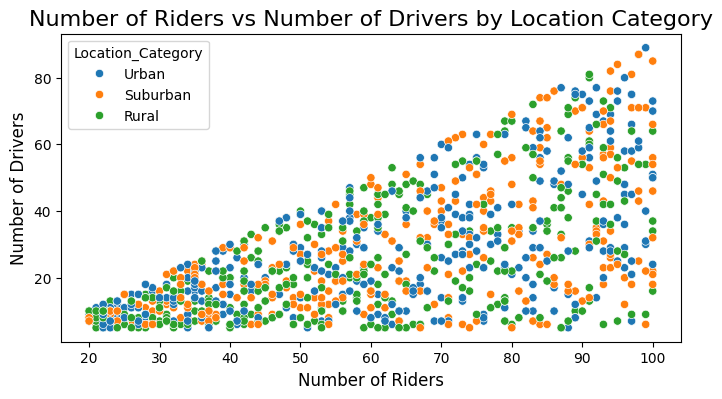

In [20]:
#Number of Riders vs Number of Drivers by Location Category
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Number_of_Riders', y='Number_of_Drivers', data=cleaned_df, hue='Location_Category')
plt.title('Number of Riders vs Number of Drivers by Location Category', fontsize=16)
plt.xlabel('Number of Riders', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)
plt.show()

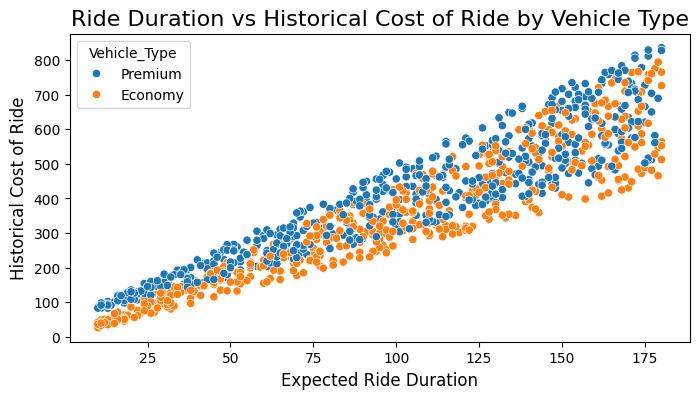

In [21]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Expected_Ride_Duration', y='Historical_Cost_of_Ride', data=cleaned_df, hue='Vehicle_Type')
plt.title('Ride Duration vs Historical Cost of Ride by Vehicle Type', fontsize=16)
plt.xlabel('Expected Ride Duration', fontsize=12)
plt.ylabel('Historical Cost of Ride', fontsize=12)
plt.show()

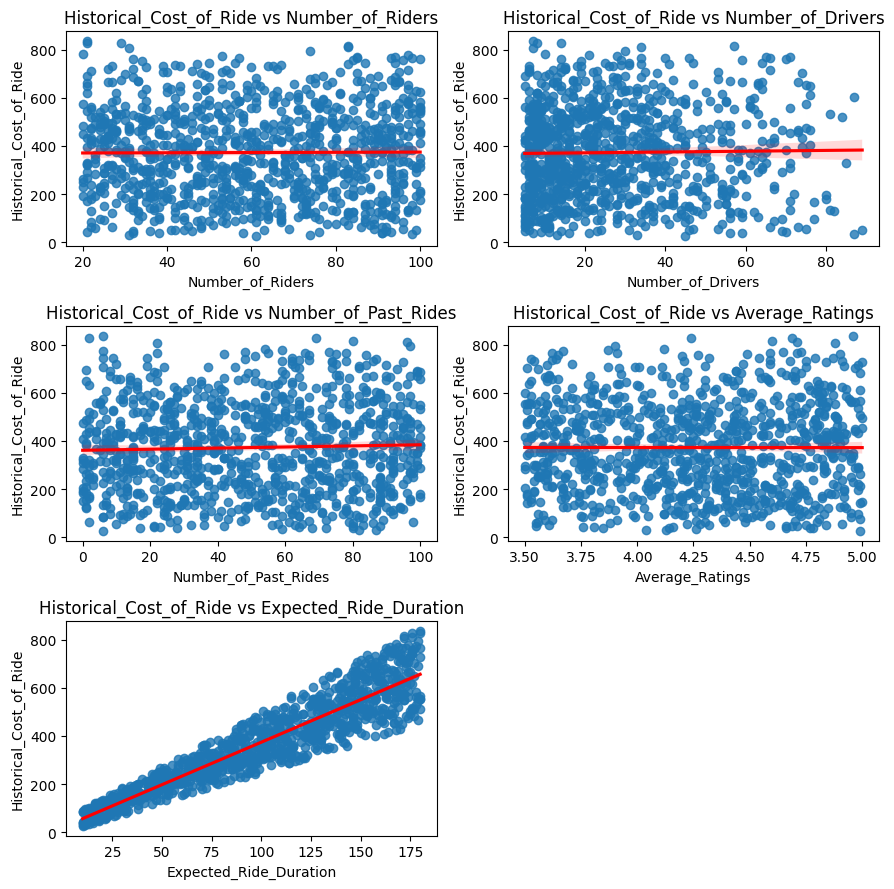

In [22]:
num_cols = len(numeric_cols)
cols = 2  
rows = math.ceil((num_cols - 1) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(9, 3 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[0:5]):
    sns.regplot(x=cleaned_df[col],y=cleaned_df[numeric_cols[5]], ax=axes[i], scatter=True, line_kws={'color': 'red'})
    axes[i].set_title(f'{numeric_cols[5]} vs {col}')
    axes[i].set_ylabel(numeric_cols[5])
    axes[i].set_xlabel(col)

# To Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

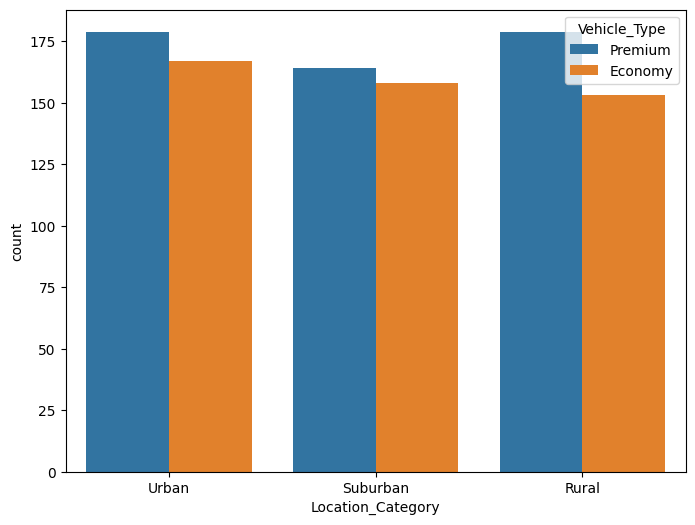

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Location_Category', data=cleaned_df, hue='Vehicle_Type')
plt.show()

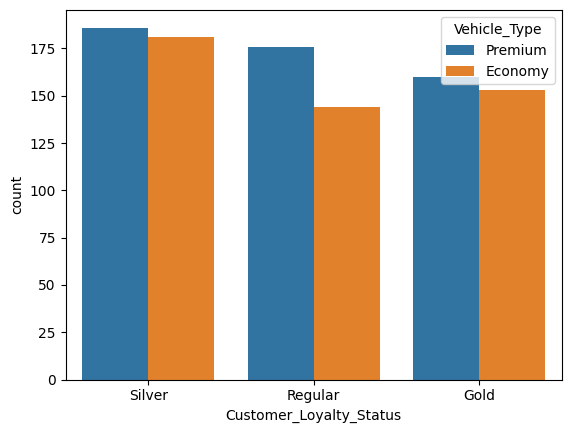

In [24]:
sns.countplot(x='Customer_Loyalty_Status', data=cleaned_df, hue='Vehicle_Type')
plt.show()

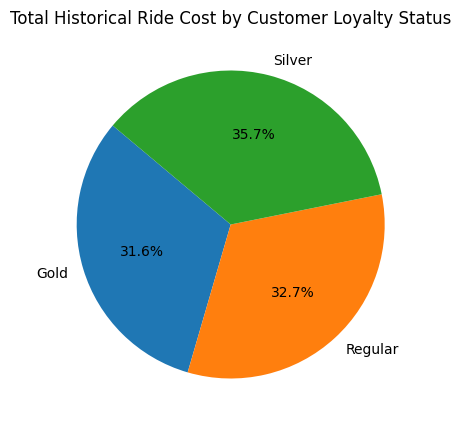

In [25]:
# Pie plot for Customer_Loyalty_Status using sum of Historical_Cost_of_Ride
loyalty_cost_sum = cleaned_df.groupby('Customer_Loyalty_Status')['Historical_Cost_of_Ride'].sum()
plt.figure(figsize=(5, 5))
plt.pie(loyalty_cost_sum, labels=loyalty_cost_sum.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Historical Ride Cost by Customer Loyalty Status')
plt.show()

## Seasonality

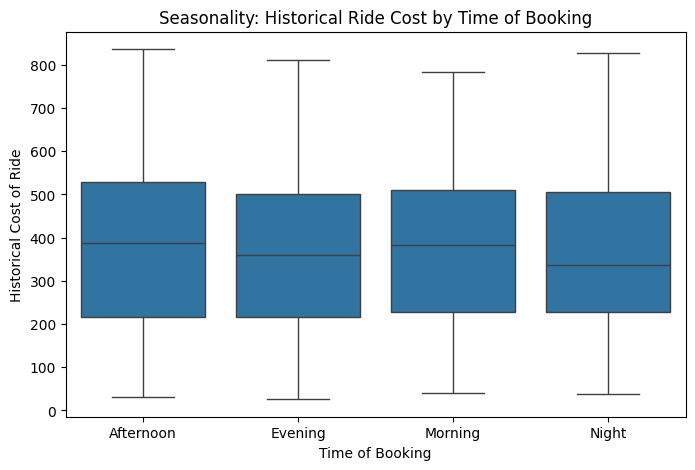

In [26]:
### using boxplot to show seasonality
plt.figure(figsize=(8, 5))
sns.boxplot(x='Time_of_Booking', y='Historical_Cost_of_Ride', data=cleaned_df, order=sorted(df['Time_of_Booking'].unique()))
plt.title('Seasonality: Historical Ride Cost by Time of Booking')
plt.xlabel('Time of Booking')
plt.ylabel('Historical Cost of Ride')
plt.show()

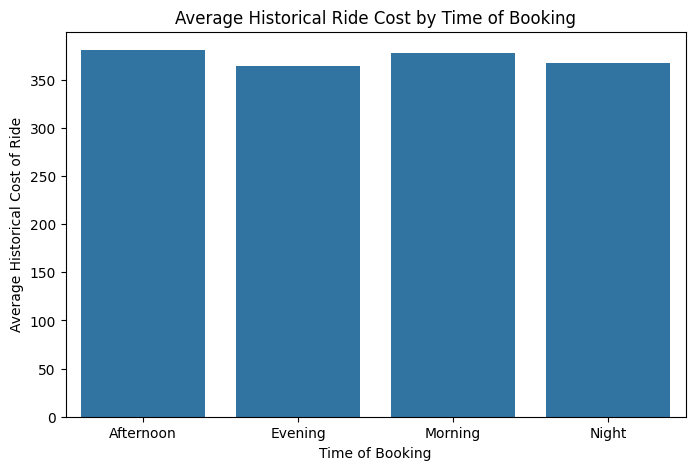

In [27]:
# Group by 'Time_of_Booking' and plot the mean Historical_Cost_of_Ride
grouped = cleaned_df.groupby('Time_of_Booking')['Historical_Cost_of_Ride'].mean().reindex(sorted(cleaned_df['Time_of_Booking'].unique()))
plt.figure(figsize=(8, 5))
sns.barplot(x=grouped.index, y=grouped.values)
plt.title('Average Historical Ride Cost by Time of Booking')
plt.xlabel('Time of Booking')
plt.ylabel('Average Historical Cost of Ride')
plt.show()

## **Milestone 4: Baseline Pricing Engine**
### **Objective: Create a rule-based engine for initial comparison.**

In [28]:
def time_multiplier_map():
    return {
        "Morning": 1.05,
        "Afternoon": 1.00,
        "Evening": 1.10,
        "Night": 1.15
    }

def inventory_multiplier(riders, drivers):
    # Simple inventory-based pricing: increase when riders >> drivers, discount when drivers >>riders
    drivers = max(1, drivers) 
    ratio = riders / drivers
    if ratio > 2.0:
        return 1.20
    if ratio > 1.5:
        return 1.10
    if ratio < 0.7:
        return 0.90
    return 1.00

def apply_rule_based_pricing(df, elasticity=-0.9):
    """
    elasticity: price elasticity of demand (negative). Example -0.9 means 1% price increase -> 0.9% drop in quantity.
    """
    tmap = time_multiplier_map()
    df = df.copy()
    # baseline assumptions
    df['base_price'] = df['Historical_Cost_of_Ride']          
    df['base_qty'] = df['Number_of_Riders'].astype(float)  
    # To compute multipliers and new price
    df['time_mult'] = df['Time_of_Booking'].map(tmap).fillna(1.0) # default 1.0 if missing
    df['inv_mult'] = df.apply(lambda r: inventory_multiplier(r['Number_of_Riders'], r['Number_of_Drivers']), axis=1)
    df['price_mult'] = df['time_mult'] * df['inv_mult']
    df['dyn_price'] = df['base_price'] * df['price_mult']
    #  new_qty = base_qty * (dyn_price / base_price) ** elasticity
    df['price_ratio'] = df['dyn_price'] / df['base_price'].replace(0, np.nan) # to avoid division by zero
    df['qty_mult'] = df['price_ratio'].fillna(1.0) ** elasticity
    df['dyn_qty'] = df['base_qty'] * df['qty_mult']
    # revenues
    df['base_revenue'] = df['base_price'] * df['base_qty']
    df['dyn_revenue'] = df['dyn_price'] * df['dyn_qty']
    # aggregate metrics
    total_base_rev = df['base_revenue'].sum()
    total_dyn_rev = df['dyn_revenue'].sum()
    revenue_lift_pct = ((total_dyn_rev - total_base_rev) / total_base_rev) * 100
    results = {
        'total_base_revenue': total_base_rev,
        'total_dynamic_revenue': total_dyn_rev,
        'revenue_lift_pct': revenue_lift_pct
    }
    return df, results

# Run the rule-based engine on the cleaned dataset
results_df, sim_metrics = apply_rule_based_pricing(cleaned_df, elasticity=-0.9)

print(f"Static total revenue: {sim_metrics['total_base_revenue']:.2f}")
print(f"Rule-based total revenue: {sim_metrics['total_dynamic_revenue']:.2f}")
print(f"Simulated revenue lift: {sim_metrics['revenue_lift_pct']:.2f}% (elasticity = -0.9)")

# Breakdown by Time_of_Booking to inspect where lift occurs
time_summary = results_df.groupby('Time_of_Booking')[['base_revenue', 'dyn_revenue']].sum()
time_summary['lift_pct'] = ((time_summary['dyn_revenue'] - time_summary['base_revenue']) / time_summary['base_revenue']) * 100
print("\nRevenue breakdown by Time_of_Booking:")
print(time_summary)

results_df.head()

Static total revenue: 22514545.02
Rule-based total revenue: 22968100.96
Simulated revenue lift: 2.01% (elasticity = -0.9)

Revenue breakdown by Time_of_Booking:
                 base_revenue   dyn_revenue  lift_pct
Time_of_Booking                                      
Afternoon        5.488150e+06  5.556838e+06  1.251566
Evening          5.203018e+06  5.321445e+06  2.276102
Morning          5.514224e+06  5.613986e+06  1.809182
Night            6.309153e+06  6.475833e+06  2.641872


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,...,base_qty,time_mult,inv_mult,price_mult,dyn_price,price_ratio,qty_mult,dyn_qty,base_revenue,dyn_revenue
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,...,90.0,1.15,1.1,1.265,359.585450,1.265,0.809317,72.838507,25583.154572,26191.667415
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,...,58.0,1.10,1.0,1.100,191.262228,1.100,0.917797,53.232220,10084.735659,10181.312965
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,...,42.0,1.00,1.0,1.000,329.795469,1.000,1.000000,42.000000,13851.409696,13851.409696
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,...,89.0,1.00,1.2,1.200,564.241478,1.200,0.848666,75.531287,41847.909626,42617.885056
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,...,78.0,1.00,1.2,1.200,695.617707,1.200,0.848666,66.195959,45215.150944,46047.081514


 ### Ordinal Encoding For Ordinal Categorical Features and One-Hot Encoding For Nominal Categorical Features

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_df.drop(columns=['Historical_Cost_of_Ride']),cleaned_df['Historical_Cost_of_Ride'],test_size=0.2, random_state=42)

In [30]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [31]:
trf1=ColumnTransformer(transformers=[('ord1', OrdinalEncoder(categories=[['Regular','Silver','Gold']]), [3])],remainder='passthrough') # Changed 'Customer_Loyalty_Status' to index 3

In [32]:
trf2=ColumnTransformer(transformers=[('ord2', OrdinalEncoder(categories=[['Economy','Premium']]), [7])],remainder='passthrough') # Changed 'Vehicle_Type' to index 7

In [33]:
trf3=ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse_output=False,drop='first',dtype=np.int32), [2,6])
], remainder='passthrough') # Changed 'Location_Category' and 'Time_of_Booking' to indices 2 and 6

In [34]:
trf4=ColumnTransformer([('scale',StandardScaler(),slice(0,12))])

## USING PIPELINE 

### Created Pipeline


In [35]:
from sklearn.pipeline import Pipeline

In [36]:
pipe=Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
    ('trf4',trf4)
])

In [37]:
from sklearn import set_config
set_config(display='diagram')

In [38]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord1',
                                                  OrdinalEncoder(categories=[['Regular',
                                                                              'Silver',
                                                                              'Gold']]),
                                                  [3])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord2',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Premium']]),
                                                  [7])])),
                ('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                sparse_output=False),
                                                  [2, 6])])),
                ('trf4',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  slice(0, 12, None))]))])

In [39]:
pipe.transform(X_test).shape

(200, 12)

In [40]:
pipe.named_steps

{'trf1': ColumnTransformer(remainder='passthrough',
                   transformers=[('ord1',
                                  OrdinalEncoder(categories=[['Regular',
                                                              'Silver',
                                                              'Gold']]),
                                  [3])]),
 'trf2': ColumnTransformer(remainder='passthrough',
                   transformers=[('ord2',
                                  OrdinalEncoder(categories=[['Economy',
                                                              'Premium']]),
                                  [7])]),
 'trf3': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehot',
                                  OneHotEncoder(drop='first',
                                                dtype=<class 'numpy.int32'>,
                                                sparse_output=False),
                                  [2, 6])]),
 'trf4': Co

In [41]:
pipe.named_steps['trf1'].get_feature_names_out()

array(['ord1__Customer_Loyalty_Status', 'remainder__Number_of_Riders',
       'remainder__Number_of_Drivers', 'remainder__Location_Category',
       'remainder__Number_of_Past_Rides', 'remainder__Average_Ratings',
       'remainder__Time_of_Booking', 'remainder__Vehicle_Type',
       'remainder__Expected_Ride_Duration'], dtype=object)

In [42]:
ordinal_encoder2 = pipe.named_steps['trf2'].transformers_[0][1]
ordinal_encoder2.categories_

[array(['Economy', 'Premium'], dtype=object)]